# traP Competition #01 (traP × 日経 Kaggle コンペティション) へようこそ！ 🗞️🙌

このコンペでは、GitHub レポジトリの
- star
- issue
- pull request
- commit
などのデータから、**将来そのレポジトリがアクティブであるか？** を予測する精度を競います！

このノートブックは Starter Notebook です。

**このノートブックを一通り読んで実行すれば、ひとまずコンペには参加できるようになっているので、ぜひ最後まで読んでください！**

## Table of Contents

1. 最初に確認して欲しいこと
2. データを読み込んでみよう
3. 他のファイルからデータを取得してみよう
4. 特徴量エンジニアリングをしよう
5. モデルを訓練してみよう
6. 予測・Submit してみよう
7. What's Next ?

## 最初に確認して欲しいこと

このノートブックを読み進める前に、まず最初にいくつかチェックして欲しい文章があります！


まず必ず目を通して欲しいのがルールです: https://www.kaggle.com/competitions/tracon01/rules

ルールに違反する行為があった場合、順位表からチームを削除せざるを得ないので、注意してください！
(とくに Private Sharing をやってしまうチームがよくいます。気をつけましょう！)


Overview にはコンペの概要が書いてあります。これを見ればコンペの概要が理解できるようになっています: https://www.kaggle.com/competitions/tracon01/overview


続いて、Data には今回のコンペで使うデータについての説明が書いてあります。こちらに先に目を通しておくとこの Notebook も読みやすくなると思います: https://www.kaggle.com/competitions/tracon01/data

## データを読み込んでみよう

上の文章たちを読んだら、まずは予測に使うデータを読み込んでチェックしてみましょう！

今回提供されるファイルは以下の通りですが、

- train.csv - 学習用データ
- test.csv - テスト用データ
- sample_submission.csv - 提出用サンプル
- repo.csv - レポジトリのメタデータ
- commits_full.csv - コミットのデータ
- commits_sampled_10.csv - コミットのデータから 10% サンプリングしたデータ
- commits_sampled_1.csv - コミットのデータから 1% サンプリングしたデータ
- issues.csv - issue のデータ
- pulls.csv - pull request のデータ


train.csv / test.csv が今回学習・予測の対象にするレポジトリです。

train.csv / test.csv の `repo_id` を key にして、repo.csv, commits_full.csv, issues.csv などから情報を取得できます。

(Data にある画像も参照してください！)

さて、まずは train.csv, test.csv をチェックしていきます。

この .csv という拡張子は、Comma-Separated Values の略で、カンマで区切られたデータを表すファイル形式です。

主には表形式のデータを扱う際に使われます。


これを Python で読み込んでみましょう。
Python で csvファイル (と表形式のデータ) を扱うときによく使われるのが pandas という名前のライブラリです。

pandas を使って train.csv / test.csv を読み込んでみましょう。

---

📝 最近は polars という比較的高速とされているライブラリもとても人気があり、pandas のシェアを大きく塗り替えつつあります。が、新興のライブラリなのでまだインターネット上で情報が少ないことを考慮してここでは pandas を使います。ある程度プログラムを書いたり必要事項を検索して使うことに慣れている人は、polars を使ってみてください。

In [1]:
# pandas というパッケージを読み込む.
# このあと pandas の関数を非常にたくさん使うので、 `pd` という別名をつけておく
import pandas as pd

print("読み込んだ pandas のバージョンは", pd.__version__)

読み込んだ pandas のバージョンは 2.2.3


In [2]:
# 何回もタイプするのは面倒なので、データのあるディレクトリを変数に格納しておく
DATA_DIR = '/kaggle/input/tracon01/'

In [3]:
train  = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')

`pandas` の `read_csv` 関数を使って、csvファイルを読み込むことができます。(`pd` として 読み込んだおかげで、`pandas.read_csv` でなく `pd.read_csv` と書くことができます)

中身を確認してみます。

---

📝: Jupyter Notebook は最後に評価された式の値を表示するので、`df` とだけ書いてセルを実行すると　`df` の中身が表示されます。

In [4]:
train

,repo_id,owner,repo,active
0,543a877d-cb0c-4705-92f5-acaf04706cd8,dana-i2cat,opennaas,False
1,2c471519-698f-439f-a498-fc57d198a808,salesagility,SuiteCRM,True
2,9535bc28-6bca-4843-be86-b634c2282eb9,fake-name,ReadableWebProxy,False
3,c9417209-8ae3-4352-b41e-838e194be066,AOSParadox,android_kernel_oneplus_msm8974,False
4,0292a511-920f-483e-aeff-bf743c6a41b4,ipti,br.tag,True
...,...,...,...,...
3678,8f53ae54-82a8-4674-994a-01173382734a,qudou,xmlplus,False
3679,408a5695-2023-4131-a7a8-d90422840330,midgen,cashgenUE,False
3680,187c0179-23d2-49de-bb29-867220688a48,FCP-INDI,C-PAC,True
3681,f22e99d7-7939-4a7f-8338-54ef894d5c1b,estafette,estafette-ci-builder,False


In [5]:
test

,repo_id,owner,repo
0,aae6372a-c92c-477c-b28f-d5979d2d5246,gurugio,lowlevelprogramming-university
1,424e6ca9-cd93-4ddc-a4ff-c161be69ac77,pgRouting,pgrouting
2,bbfad893-9643-4b5c-9ac6-5eab319d64e4,tensorflow,tensorflow
3,494417c4-ba3f-4c9e-878e-aca1b2fb37d0,sztupy,samsung-kernel-herring
4,e92905aa-bdd2-4cd9-b67b-1192d3ee620e,eliotsykes,real-world-rails
...,...,...,...
1810,2b671097-3b9b-4d61-bf48-44d0db76ef1d,Beaconstac,Android-SDK
1811,0e305ada-9e27-4d9b-9bbc-1f46db8db86b,NahomAgidew,eCommerce
1812,a00999a4-a1bb-4df0-8066-361de6002ff8,iolevel,peachpie-samples
1813,6791bcd6-e573-4c77-b6c0-e9bef4167c3c,fracpete,multisearch-weka-package


このように表のデータが `train`, `test` として読み込まれました。

まずはこれらの中身をきちんと確認しましょう。

In [6]:
print(type(train))
print(type(test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


`train`, `test` の中身は `DataFrame` という型のオブジェクトでした。


これは pandas で表形式のデータセットを扱う際に使われるもので、このオブジェクトには様々な便利なメソッド・プロパティがあります。

まずは一番基本的な情報である、そのサイズ: 何行何列のデータなのか？を確認してみます。

In [7]:
# train と test のデータの形を確認してみる
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (3683, 4)
test shape: (1815, 3)


train は 3700行くらいで 4列あり, test は 1800行くらいで 3列ありました。

次に、各列の情報を確認してみましょう。

In [8]:
train.describe()

,repo_id,owner,repo,active
count,3683,3683,3683,3683
unique,3683,3346,3499,2
top,543a877d-cb0c-4705-92f5-acaf04706cd8,CyanogenMod,dotfiles,False
freq,1,31,10,2698


In [9]:
test.describe()

,repo_id,owner,repo
count,1815,1815,1815
unique,1815,1710,1762
top,aae6372a-c92c-477c-b28f-d5979d2d5246,CyanogenMod,dotfiles
freq,1,11,6


`describe` メソッドを使うと、各列について
- その列のデータの個数
- ユニークな値の個数
- 最も多い値
- 最も多い値の個数
を求めてくれます。この結果を見ると、

- CyanogenMod という人 or Organization のレポジトリが最も多い
- dotfiles という名前のレポジトリが最も多い

などがわかります。dotfiles は確かに多そうですね。

続いて、今回のコンペで予測の対象になっている train.csv の active という列についても確認してみましょう。

In [10]:
train['active'].value_counts()

active
False    2698
True      985
Name: count, dtype: int64

`df[col]` という形で列を取り出すことができます。そして、列 (これは `Series` という型のオブジェクトです) に対して `value_counts` メソッドを使うと、その列に含まれる各値の個数を調べることができます。

これを見ると、大体 1000件くらいのレポジトリが active で、それ以外は inactive であることがわかります。

## 他のファイルからデータを取得してみよう

ところで今回のデータはでは train/test.csv にはこれ以外に大したデータは入っておらず、これはその他のファイルからデータをとってくるために使います。

今回は `repo.csv` を使いましょう。ここには各レポジトリの star数と fileの情報が入っています。

まずはこれを同様に読み込んでみます。(10秒くらいかかります)

In [11]:
repo = pd.read_csv(DATA_DIR + 'repo.csv')

これの中身は、

In [12]:
repo

,repo_id,stars,files
0,989d25c5-ab17-43e8-a046-814b44f4f3f7,"[{'created_at': '2015-12-21T20:24:11+00:00'}, ...","[{'name': '.gitignore', 'size': 387}, {'name':..."
1,e9dc25f7-e8e0-48fb-84a0-cbba445398f7,"[{'created_at': '2016-08-19T06:40:26+00:00'}, ...","[{'name': '.bowerrc', 'size': 59}, {'name': '...."
2,7e74d90d-30a1-4cba-bf36-a365991e7f04,"[{'created_at': '2016-04-11T18:36:21+00:00'}, ...","[{'name': '.gitmodules', 'size': 2187611}, {'n..."
3,f9e289cd-cba2-4f65-9626-923fcfe6c1cf,"[{'created_at': '2016-04-19T10:41:23+00:00'}, ...","[{'name': '.codeclimate.yml', 'size': 340}, {'..."
4,ebac9dab-958f-4ac7-8801-114c41c0b27d,"[{'created_at': '2017-07-26T20:00:34+00:00'}, ...","[{'name': '.gitignore', 'size': 881}, {'name':..."
...,...,...,...
5493,940dcbbb-9cac-4412-8cb6-b237d76845fb,"[{'created_at': '2013-08-06T17:39:33+00:00'}, ...","[{'name': '.gitignore', 'size': 367}, {'name':..."
5494,f536813a-9d5f-414f-9e0f-dda1e58188f5,"[{'created_at': '2013-05-22T16:05:26+00:00'}, ...","[{'name': '.editorconfig', 'size': 97}, {'name..."
5495,3d38df23-d225-4254-a2e6-e1a4d0fd4152,"[{'created_at': '2012-05-14T11:20:55+00:00'}, ...","[{'name': '.gitattributes', 'size': 534}, {'na..."
5496,e2a05f0d-1ca7-4553-8753-cc603290ae0c,"[{'created_at': '2014-08-27T20:46:00+00:00'}, ...","[{'name': '.babelrc', 'size': 125}, {'name': '..."


こんな感じで stars というカラムにスターの履歴, files というカラムにファイルの情報が入っています。

これをtrain/test.csv に結合したいわけですが, pandas では `merge` というメソッドを使うことで、2つの DataFrame を結合することができます。

In [13]:
pd.merge(train, repo, on='repo_id')

,repo_id,owner,repo,active,stars,files
0,543a877d-cb0c-4705-92f5-acaf04706cd8,dana-i2cat,opennaas,False,"[{'created_at': '2011-08-08T12:45:48+00:00'}, ...","[{'name': '.gitignore', 'size': 136}, {'name':..."
1,2c471519-698f-439f-a498-fc57d198a808,salesagility,SuiteCRM,True,"[{'created_at': '2013-09-24T18:49:49+00:00'}, ...","[{'name': '.codecov.yml', 'size': 1378}, {'nam..."
2,9535bc28-6bca-4843-be86-b634c2282eb9,fake-name,ReadableWebProxy,False,"[{'created_at': '2016-08-02T22:04:35+00:00'}, ...","[{'name': '.gitattributes', 'size': 285}, {'na..."
3,c9417209-8ae3-4352-b41e-838e194be066,AOSParadox,android_kernel_oneplus_msm8974,False,"[{'created_at': '2015-09-07T04:14:33+00:00'}, ...","[{'name': '.gitignore', 'size': 1020}, {'name'..."
4,0292a511-920f-483e-aeff-bf743c6a41b4,ipti,br.tag,True,"[{'created_at': '2016-03-22T13:31:17+00:00'}, ...","[{'name': '.dockerignore', 'size': 26}, {'name..."
...,...,...,...,...,...,...
3678,8f53ae54-82a8-4674-994a-01173382734a,qudou,xmlplus,False,"[{'created_at': '2017-03-11T18:11:22+00:00'}, ...","[{'name': '.gitignore', 'size': 12}, {'name': ..."
3679,408a5695-2023-4131-a7a8-d90422840330,midgen,cashgenUE,False,"[{'created_at': '2016-04-23T16:53:11+00:00'}, ...","[{'name': '.clang-format', 'size': 968}, {'nam..."
3680,187c0179-23d2-49de-bb29-867220688a48,FCP-INDI,C-PAC,True,"[{'created_at': '2020-05-28T19:09:30+00:00'}, ...","[{'name': '.circleci/config.yml', 'size': 431}..."
3681,f22e99d7-7939-4a7f-8338-54ef894d5c1b,estafette,estafette-ci-builder,False,"[{'created_at': '2017-04-11T12:44:23+00:00'}, ...","[{'name': '.estafette.yaml', 'size': 15342}, {..."


このように、train に star, そして file の情報を追加することができました。

同様に test にも追加して、それぞれ `train_merged`, `test_merged` として保存しておきます。

In [14]:
train_merged = train.merge(repo, on='repo_id', how='left')
test_merged = test.merge(repo, on='repo_id', how='left')

これで star と file のデータが集まったわけです。これを使えば色々と予測ができそうですが、まずは焦らずにデータの性質を丁寧に調べることが大切です。まずは star数の分布を調べてみましょう。

`sr.apply(f)`　で列 `sr` の各行に対して関数 `f` を適用した結果の列を得ることができます。

今回の場合、`list_len` によって starの数を調べます。
ついでにファイルの数も調べて、それぞれ "n_stars", "n_files" という名前の列として追加します。

In [15]:
def list_len(s: str):
    return s.count(',')

In [16]:
# Serise の `apply` メソッドを使って、各要素に関数を適用した結果を取得できる
train_merged['stars'].apply(list_len)

0         30
1       2680
2        170
3          4
4         11
        ... 
3678      28
3679     350
3680      24
3681      14
3682    4003
Name: stars, Length: 3683, dtype: int64

In [17]:
# それぞれ "n_stars", "n_files" という名前の列として追加しておく
train_merged["n_stars"] = train_merged["stars"].apply(list_len)
test_merged["n_stars"] = test_merged["stars"].apply(list_len)

train_merged["n_files"] = train_merged["files"].apply(list_len)
test_merged["n_files"] = test_merged["files"].apply(list_len)

ではこれの分布を調べます。グラフをプロットするときは matplotlib というライブラリがよく使われます。

今回は matplotlib の `hist` 関数を使ってヒストグラムを描きます。

In [18]:
import matplotlib.pyplot as plt

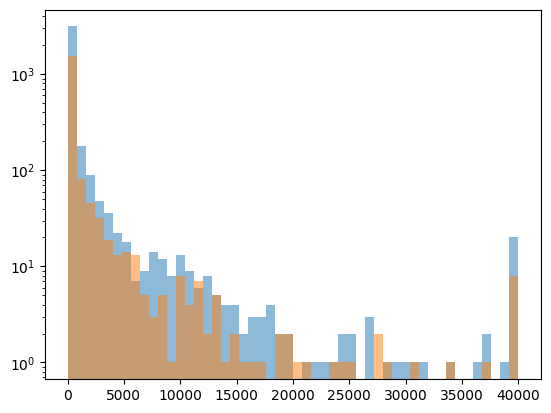

In [19]:
# train と test それぞれの n_stars の分布をプロット
plt.hist(train_merged['n_stars'], bins=50, alpha=0.5, label='train', log=True)
plt.hist(test_merged['n_stars'], bins=50, alpha=0.5, label='test', log=True)
plt.show()

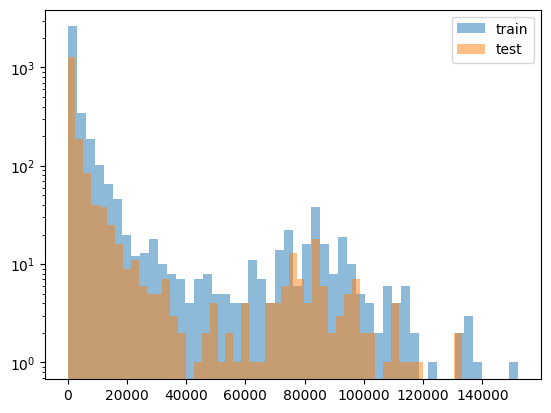

In [20]:
# train と test それぞれの n_files の分布をプロット
plt.hist(train_merged['n_files'], bins=50, alpha=0.5, label='train', log=True)
plt.hist(test_merged['n_files'], bins=50, alpha=0.5, label='test', log=True)
plt.legend()
plt.show()

このグラフから何を読み取るかは競技のうちなのであまり書きませんが、少なくとも star数 も file数 も少ないものが多そうというのはわかります。

いくつかチェックした方がいいことを書いておきます。

- 基本的な統計量
  - 当たり前ですが、サイズや最小値・最大値などを調べておきましょう！見落とすとまずい情報があるかもしれません。
- 他の変数との関係
  - 相関係数や、変数の値ごとの分布 (例: Active / InActive それぞれについて star数の分布)　などを調べておくと予測に役立つ特徴が見つかるかもしれません。 
- train/test データ間で分布の差はないか？
  - バリデーションデータを作ることによる精度の見積もりはなぜ上手くいくのでしょうか？ https://abap34.github.io/ml-lecture/ch05/lecture.pdf#48=&page=63.00 を思い出しましょう！


## 特徴量エンジニアリングをしよう

さて、star数 と file数が手に入っているわけですが、このような各レコードが持つ特徴を表現する定量的な量を「特徴量」と呼びます。

さらに、この二つはどう考えても「アクティブかどうか？」という結果を予測する上で役に立つ量です。
このような予測に役立つ特徴量を取得しておいてあげることで予測精度を高めることができます。


また、外から取得するだけでなく既存の特徴を組み合わせたり加工することでもいくつかのメリットを享受することができます。


例えば star数 と file数 という二つの特徴から新しい特徴を作ることを考えてみましょう。


例えば「star数 のわりに file数 が多いレポジトリは、やりがいの割にメンテナンスコストが高くて開発者のモチベ維持が大変そうではないか？」というような仮説を考えることができます。


そこで、

In [21]:
# files数 と star数 の比率を計算 
train_merged["star_file_ratio"] = train_merged["n_files"] / train_merged["n_stars"]
test_merged["star_file_ratio"] = test_merged["n_files"] / test_merged["n_stars"]

という列を追加してみます。

この列の追加によって、予測モデルに入力される情報の情報量自体は増えていません。


しかし、明示的にこのような列を追加してやることによって (もしこの特徴量が予測する上で有用だとしたら)　確実にモデルに拾ってもらえること、また学習時間の短縮などが見込めます。


このような、予測に役立たせることを目指して様々な特徴量を作ることを

「特徴量エンジニアリング」と言います。


データを調べて仮説をたて、その仮説に基づいて特徴量エンジニアリングをすることこそが表形式のコンペで大きな差別化ポイントになるところです。


データをよく調べて、色々な特徴量を作ってみましょう。

---

📝: そのほかコンペの戦い方などは機械学習講習会の第７回を見てください: https://abap34.github.io/ml-lecture/

## モデルを訓練しよう

では、このスター数とファイル数からアクティブさを予測するモデルを作ってみましょう！

機械学習講習会 (とそのコンペ) にでた人はバリデーションの大切さが身に沁みているかと思います。

今回は **Cross Validation** を使ってモデルの汎化性能を評価します。

In [22]:
from sklearn.model_selection import KFold

# ⇩ 運試しに、random_state を好きな数字に変えましょう！
kf = KFold(n_splits=4, shuffle=True, random_state=34)

In [23]:
# 使うカラムと予測対象のカラム
use_cols = ["n_stars", "n_files", "star_file_ratio"]
target_col = "active"

今回は、学習データを 4つに分割して、そのうちの 3つを学習データに、残り二つをバリデーションデータに使うというのを 4回繰り返します。

In [24]:
for train_index, valid_index in kf.split(train_merged):
    train_data = train_merged.iloc[train_index]
    valid_data = train_merged.iloc[valid_index]
    print("学習データの数:", len(train_data), "検証データの数:", len(valid_data))

学習データの数: 2762 検証データの数: 921
学習データの数: 2762 検証データの数: 921
学習データの数: 2762 検証データの数: 921
学習データの数: 2763 検証データの数: 920


大体 3:1 くらいに分割されていることがわかります。


実際に学習を行う部分を作ります。


今回は、モデルとして GBDT (勾配ブースティング木) を使います。今回のような表形式データに対しては非常に強力なことが知られているモデルです。

GBDT を使うためのライブラリとして、**lightgbm** を使います。とても人気がある高精度で高速な GBDT の学習の実装です。

In [25]:
import lightgbm as lgb

# 各分割をもらって、lightgbm のモデルを訓練して訓練した後のモデルを返す関数
def train_fold(train_X: pd.DataFrame, train_y: pd.Series, valid_X: pd.DataFrame, valid_y: pd.Series) -> lgb.Booster:
    # データセットを作成
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_valid = lgb.Dataset(valid_X, valid_y, reference=lgb_train)

    params = {
        # 二値分類として解く
        'objective': 'binary',
        # 評価指標として auc と accuracy を使う
        'metric': ['auc', 'accuracy'],
    }

    # 学習. auc が 100ステップ以上改善しないなら打ち切るように設定する
    model = lgb.train(params, lgb_train, valid_sets=[lgb_valid], callbacks=[lgb.early_stopping(100, first_metric_only=True)])

    return model

In [26]:
# 学習！

models = []

for train_index, valid_index in kf.split(train_merged):
    train_data = train_merged.iloc[train_index]
    valid_data = train_merged.iloc[valid_index]

    train_X = train_data[use_cols]
    train_y = train_data[target_col]

    valid_X = valid_data[use_cols]
    valid_y = valid_data[target_col]

    model = train_fold(train_X, train_y, valid_X, valid_y)

    models.append(model)

[LightGBM] [Info] Number of positive: 741, number of negative: 2021
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2762, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268284 -> initscore=-1.003347
[LightGBM] [Info] Start training from score -1.003347
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.778065
Evaluated only: auc
[LightGBM] [Info] Number of positive: 740, number of negative: 2022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2762, number of used features: 3


無事に学習が終わりました。**ここからがとても大事です。**


きちんと性能を評価しましょう。まずは、バリデーションデータに対する予測結果を計算します。

In [27]:
# `oof_pred` に今回訓練したモデルたちによる予測結果を格納する
 
import numpy as np

oof_pred = np.zeros(len(train_merged))

for i, (train_index, valid_index) in enumerate(kf.split(train_merged)):
    # バリデーションデータを取り出す
    valid_data = train_merged.iloc[valid_index]
    valid_X = valid_data[use_cols]

    # 予測結果を出力
    oof_pred[valid_index] = models[i].predict(valid_X)

これを使って、テストデータに対する予測の精度を見積もります。今回のコンペの評価指標である ROC-AUC は scikit-learn というライブラリから利用できます。

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve

score = roc_auc_score(train_merged["active"], oof_pred)

print(score)

0.7716196994953961


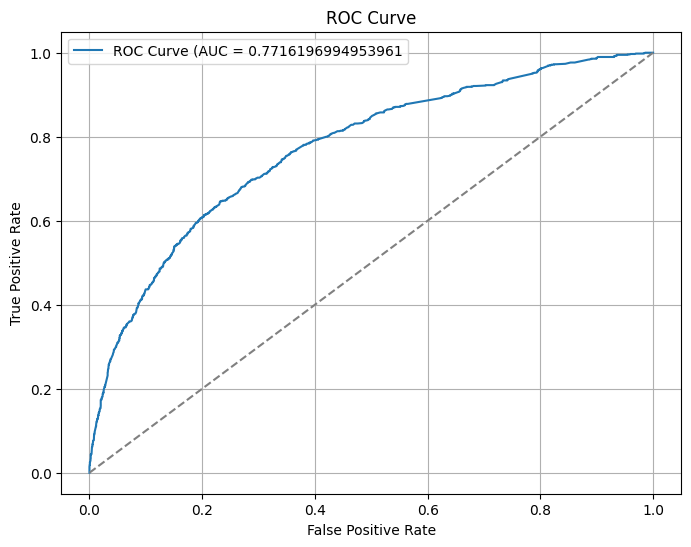

In [29]:
# ROC 曲線のプロット
fpr, tpr, thresholds = roc_curve(train_merged["active"], oof_pred)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {score}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # ランダムな分類器の基準線
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


AUC: 0.771...  という結果が得られました！

このスコアを上げていくことが目標です。


他にも調べておくべきこととして、**特徴量の重要度** があります。


いくらかのアルゴリズムでは、「予測にあたって各特徴量をどれくらい重視したのか？」という量を計算することができます。
(feature importance などと呼ばれます)


学習が終わったらこれを確認することで、特徴量エンジニアリングで作った特徴が実際どのくらい有用だったか？　を確かめることができます。


ここでは lightgbm で feature importtance を計算してプロットする例を掲載します。　

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_importance(models: list):
    feature_importance = pd.DataFrame()
    
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = model.feature_name()
        _df['fold'] = i + 1
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)

    order = feature_importance.groupby('column').sum()[['feature_importance']].sort_values('feature_importance', ascending=False).index

    plt.figure(figsize=(6, 4))
    sns.boxenplot(data=feature_importance, x='feature_importance', y='column', order=order)
    plt.title('feature importance')
    plt.grid()
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


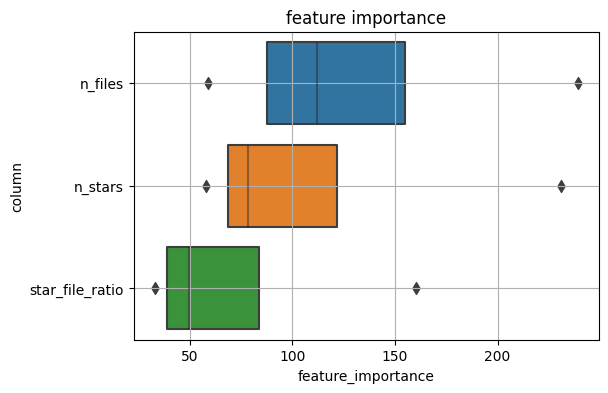

In [31]:
plot_importance(models)

これをみると、

file数 > star数 > star数 と file数 の比率

で重視されていることがわかりますね。


また、予測値の分布もチェックしておくと変なバグに気がつきやすいのでやっておくと良いです。

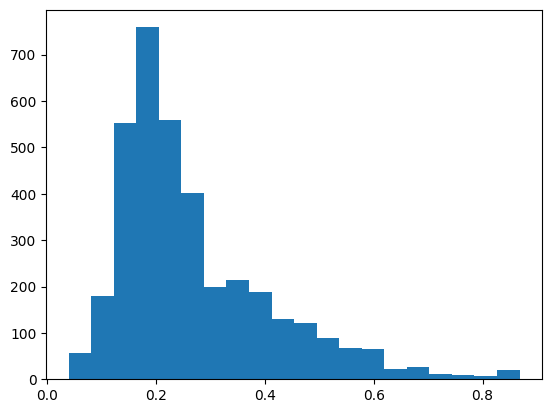

In [32]:
plt.hist(oof_pred, bins=20)
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix

他にも例えば 予測がうまくいっていない例を確認するなどは役に立つことが多いです。

しょうがない例なのか、何か情報が伝わっていないのかを調べて、もし後者なら伝えられる特徴量を考えましょう！

## 予測・Submit してみよう

ここまで来れば、あとは予測をしてその結果を Submit するだけです！

今回はモデルが 4つありますからこれらの予測の平均をとって最終予測とします。

提出ファイルのためにフォーマットを揃えるには `sample_submission.csv` を使うのが便利です。

In [34]:
pd.read_csv(DATA_DIR + 'sample_submission.csv')

,id,pred
0,aae6372a-c92c-477c-b28f-d5979d2d5246,0.928556
1,424e6ca9-cd93-4ddc-a4ff-c161be69ac77,0.779127
2,bbfad893-9643-4b5c-9ac6-5eab319d64e4,0.377903
3,494417c4-ba3f-4c9e-878e-aca1b2fb37d0,0.381512
4,e92905aa-bdd2-4cd9-b67b-1192d3ee620e,0.666380
...,...,...
1810,2b671097-3b9b-4d61-bf48-44d0db76ef1d,0.596171
1811,0e305ada-9e27-4d9b-9bbc-1f46db8db86b,0.684157
1812,a00999a4-a1bb-4df0-8066-361de6002ff8,0.410451
1813,6791bcd6-e573-4c77-b6c0-e9bef4167c3c,0.811224


このファイルは予測結果の列: pred にはランダムな値が入っていますが提出ファイルとして完全にフォーマットが整っています。

このファイルの pred を実際の予測結果で置き換えてしまってそれを提出するのが一番手っ取り早いです。

In [35]:
sample_sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')

pred = np.zeros(sample_sub.shape[0])

for model in models:
    pred += model.predict(test_merged[use_cols])

pred /= len(models)

sample_sub["pred"] = pred

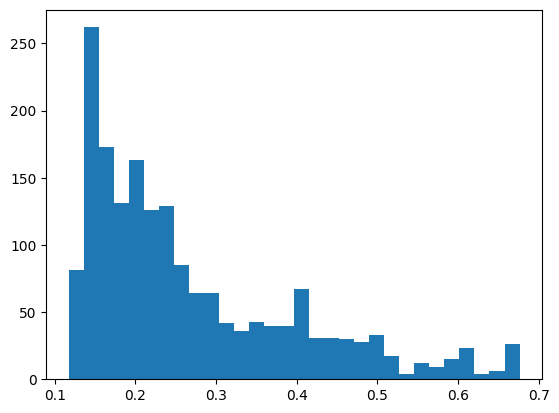

In [36]:
plt.hist(pred, bins=30)
plt.show()

あとはこれを保存して、提出すれば完了です！お疲れ様でした！

In [37]:
sample_sub.to_csv("submission.csv", index=False)

## What's Next?

このノートブックでは、repo.csv から得られる star と file の情報だけを使いました。


しかし、コミットのデータや issue, pull requests のデータは間違いなく役に立つものなので、まずはこのあたりのデータからいけそうなものを使うのがいいでしょう。


ただし、これらはサイズも大きいので、うまく部分的に利用していくと良さそうです。


特にコミットのデータは大きいですから、10%・1% 単にランダムにサンプリングしたものもあります。これらも活用してみてください。


---

データなどについて質問があれば Discussion を立ててもらうか Slack に書いてください。

また、実装で困った場合の質問には答えられるので、気軽に質問してください 🙌

以下のような質問には答えられます！

- {具体的な処理の内容} を実装したいが、どのようにやればいいのかわからない
- {具体的なアルゴリズム} を使いたいが、ライブラリを知らない
- エラーが解決できなくて困った！

逆に、例えば

- こういう気持ちを反映させたデータの加工をしたいけど、具体的にどういうことをすればいいか教えてほしい

というようなアイデアを含む質問は答えられません！
が、とりあえず聞いてもらえたら答えられるかどうかを含めて回答するので、とりあえず投げることをお勧めします！

(そして、ChatGPT は心強い実装のお供なことも忘れずに)


### それでは、優勝目指して 1週間がんばりましょう！🏃‍♀️💨